<html>
  <head>
    <title>Pretty Paris</title>
  </head>
  <style>
  .container {
  </style>
  <body>
    <div class="container">
    <div class="text">
      <h1>Physics-Constrained-Machine-Learning-Example Demonstration</h1>
        <p>Author: Austin Downey, Ph.D. <br> 
        Assisted by: Puja Chowdhury <br> 
Inspired by: https://github.com/benmoseley/harmonic-oscillator-pinn</p>
      
  
<!-- # PINN Demonstration -->
<!-- Author: Austin Downey, Ph.D.\  -->
<!-- <img src="./figures/downey.jpg" alt="downey" width="100" align="left"/> -->
<!-- Assisted by: Puja Chowdhury \ -->
<!-- Inspired by: https://github.com/benmoseley/harmonic-oscillator-pinn -->

### Step 1: Importing the libraries

In [101]:
# library
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
# Enable interactive plots
%matplotlib inline

### Setp 2: Data generation
<img src="./figures/beam.jpg" alt="beam" width="750"/>
<!-- ![beam](./figures/beam.jpg) -->

#### Step 2.1: Defining function

In [102]:
## Defining function
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

#### Step 2.2: Calling the "oscillator" function to generate the data

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


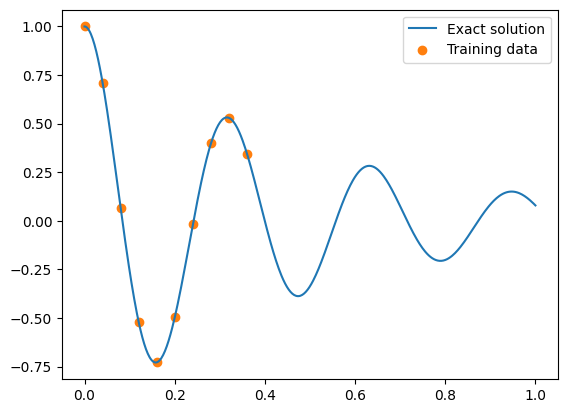

In [103]:
#%%     Generate training data
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

#### Other customized function (plotting purpose)

In [104]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60,  alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")
    

### Step 3 :  Model

<img src="./figures/main.png" alt="model" width="750"/>
<!-- ![model](./figures/main.png) -->

#### Step 3.1: Designing model

In [105]:
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x


#### Step 3.2: Defining  NN (neural network) model (fitting model to experimental data)

In [106]:
#%% Normal neural network
# train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)    

#### Step 3.3: Training

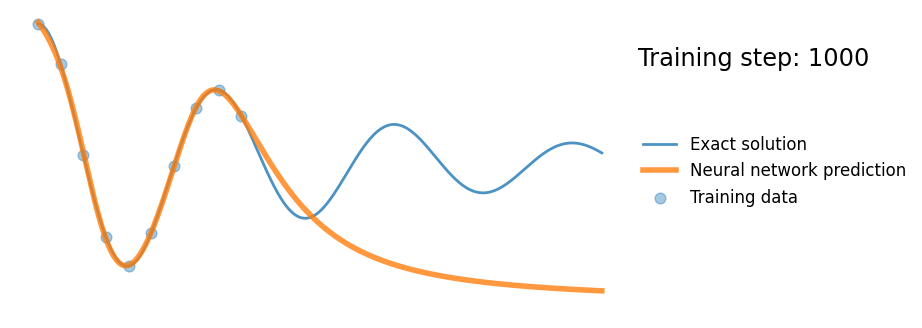

In [107]:
files = []
for i in range(1000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 1000 == 0: 
        
        yh = model(x).detach()
        
        plot_result(x,y,x_data,y_data,yh)
        
        file = "plots/nn_%.8i.pdf"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (i+1) % 500 == 0: 
            plt.show()
        else: 
            plt.close("all")

#### Step 3.4: Defining PINN (Physics-informed neural network) model. (Adding Physics loss)

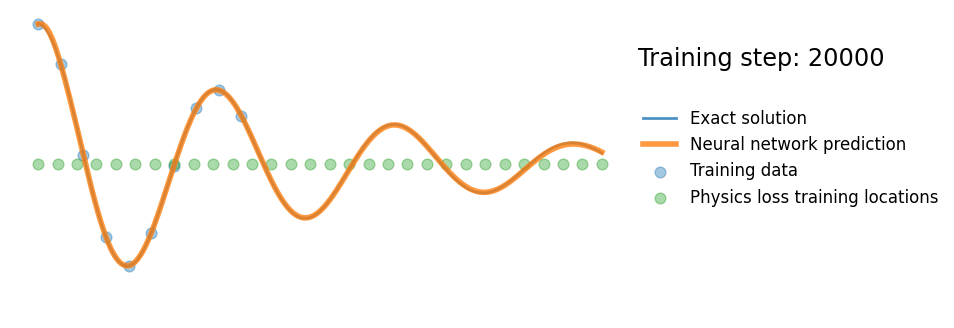

In [108]:
#%% PINN
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
mu, k = 2*d, w0**2

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4) # original lr=1e-4
files = []
for i in range(20000):
    optimizer.zero_grad()
    
    # compute the "data loss"
    yh = model(x_data)
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error
    
    # compute the "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (1e-4)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss1 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 20000== 0: # if (i+1) % 150 == 0: 
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plot_result(x,y,x_data,y_data,yh,xp)
        
        file = "plots/pinn_%.8i.pdf"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 20000 == 0: 
            plt.show()
        else: 
            plt.close("all")
            
# save_gif_PIL("pinn.gif", files, fps=20, loop=0)

### Step 4: Analysis

Physics constrained loss effect in the one degree of freedom cantilever beam model with
* a constant angular frequency, wo = 25 Hz 
* various damping coefficient, d = 1;2;3;4;5;10. \

<img src="./figures/various_damping_coefficient.png" alt="various_damping_coefficient" width="600"/>
<!-- ![various_damping_coefficient](./figures/various_damping_coefficient.png) -->

Physics constrained loss effect in the one degree of freedom cantilever beam model with 
* various angular frequency, wo = 15;25;35 Hz
* various damping coefficient, d = 2;3;4 \

<img src="./figures/various_damping_coefficient_various_freq.png" alt="various_damping_coefficient_various_freq" width="600"/>
<!-- ![various_damping_coefficient_various_freq](./figures/various_damping_coefficient_various_freq.png) -->

#### Contact
Email: austindowney@sc.edu \
ARTS-Lab: https://cse.sc.edu/~adowney2/ \
<img src="./figures/Thankyou.png" alt="ThankYou" width="400"/>
<!-- [ThankYou](./figures/Thankyou.png) -->

[Picture Source](https://si.discountshoponline2023.com/category?name=thank%20you%20robot)